Import the required libraries

In [1]:
import os
import gc
import sys
import cv2
import random
import os.path
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

print("TensorFlow version:", tf.__version__)
warnings.filterwarnings('ignore')

TensorFlow version: 2.10.1


In [2]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
from csv import DictWriter

from tensorflow.keras.layers import BatchNormalization, Layer, Dense, Flatten, Concatenate, Input, InputLayer, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D
from keras.utils import to_categorical, img_to_array, array_to_img, Sequence
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers 

# CNN 1 and 2 use K49 dataset while model 3 uses KMNIST dataset
# CNN 1 uses SMOTE-d data while CNN 2 uses normal unsampled data
# Try concatenating the models or using argmax for each model and getting the highest weight for each prediction

In [3]:
def setSeed(seed=404):
    np.random.seed(seed) 
    tf.random.set_seed(seed) 
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

Read in the Kuzushiji-49 and KMNIST dataset

In [4]:
# Sets the necessary filepath to the current working directory (same as notebook)
k49Path = os.getcwd() + "\\datasets\\K49\\"

kmnistPath= os.getcwd() + "\\datasets\\KMNIST\\"

In [5]:
trainData = np.load(k49Path + 'k49-train-imgs.npz')['arr_0']
trainLabel = np.load(k49Path + 'k49-train-labels.npz')['arr_0']
testData = np.load(k49Path + 'k49-test-imgs.npz')['arr_0']
testLabel = np.load(k49Path + 'k49-test-labels.npz')['arr_0']

labelIndices = pd.read_csv(k49Path + 'k49_classmap.csv')

trainDataKMNIST = np.load(kmnistPath + 'kmnist-train-imgs.npz')['arr_0']
trainLabelKMNIST = np.load(kmnistPath + 'kmnist-train-labels.npz')['arr_0']
testDataKMNIST = np.load(kmnistPath + 'kmnist-test-imgs.npz')['arr_0']
testLabelKMNIST = np.load(kmnistPath + 'kmnist-test-labels.npz')['arr_0']

labelIndicesKMNIST = pd.read_csv(kmnistPath + 'kmnist_classmap.csv')

Check shape of the datasets

In [6]:
# Try using SMOTE to balance minority class
# Try feeding training chunks in order to make full use of the dataset

print('trainData shape :', trainData.shape)
print('trainLabel shape : ', trainLabel.shape)
print('testData shape : ', testData.shape)
print('testLabel shape : ', testLabel.shape)

trainData shape : (232365, 28, 28)
trainLabel shape :  (232365,)
testData shape :  (38547, 28, 28)
testLabel shape :  (38547,)


In [7]:
print('trainData shape :', trainDataKMNIST.shape)
print('trainLabel shape : ', trainLabelKMNIST.shape)
print('testData shape : ', testDataKMNIST.shape)
print('testLabel shape : ', testLabelKMNIST.shape)

trainData shape : (60000, 28, 28)
trainLabel shape :  (60000,)
testData shape :  (10000, 28, 28)
testLabel shape :  (10000,)


Resample the K49 dataset using SMOTE for the first CNN

In [8]:
nsamples, nx, ny = trainData.shape
flattenedTrainData = trainData.reshape((nsamples,nx*ny))

# Synthetically create new data for minority class to match 
smote = SMOTE(random_state = 42)
resampledTrainData, resampledTrainLabel = smote.fit_resample(flattenedTrainData, trainLabel)
reshapedSampledTrain = np.reshape(resampledTrainData, (resampledTrainData.shape[0], nx, ny))

# Print out the shapes of the newly sampled train dataset
print(reshapedSampledTrain.shape)
print(resampledTrainLabel.shape)

(294000, 28, 28)
(294000,)


In [9]:
uniqueTrainLabels, uniqueTrainIndices = np.unique(trainLabel, return_counts=True)
uniqueSampledTrainLabels, uniqueSampledTrain = np.unique(resampledTrainLabel, return_counts=True)

print("Index of smallest unique value in train set before SMOTE:", np.argmin(uniqueTrainIndices))
print("Smallest value in train set before SMOTE:", uniqueTrainIndices.min())

print("Index of smallest unique value in train set before SMOTE:", np.argmin(uniqueSampledTrain))
print("Smallest value in train set before SMOTE:", uniqueSampledTrain.min())

Index of smallest unique value in train set before SMOTE: 45
Smallest value in train set before SMOTE: 392
Index of smallest unique value in train set before SMOTE: 0
Smallest value in train set before SMOTE: 6000


In [10]:
def reshapeImage(image, newSize): # Image resizing function for transfer model
    img = array_to_img(image, scale = False) # return PIL Image
    img = img.resize((newSize, newSize)) # resize the image
    img = img.convert(mode = 'RGB') # caonverts to 3 channels
    imgArray = img_to_array(img) # convert back to array
    return imgArray.astype(np.float64)

In [11]:
# Reshape images as per the tensor format required by tensorflow

reshapedTrain = (trainDataKMNIST.reshape(-1,28,28,1))
reshapedTest = (testDataKMNIST.reshape(-1,28,28,1))

# Normalize test dataset
testData = testData / 255

In [12]:
# Resize the images to match the required input of the models
newSize = 64

resizedTrainKMNIST = np.array([reshapeImage(img, newSize) for img in reshapedTrain])
resizedTestKMNIST = np.array([reshapeImage(img, newSize) / 255 for img in reshapedTest])

resizedTrainKMNIST.shape, resizedTestKMNIST.shape

((60000, 64, 64, 3), (10000, 64, 64, 3))

In [13]:
print(labelIndices.head())

   index codepoint char
0      0    U+3042    あ
1      1    U+3044    い
2      2    U+3046    う
3      3    U+3048    え
4      4    U+304A    お


In [14]:
print(labelIndicesKMNIST)

   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


Create mapping for KMNIST labels to K49 labels for future training and predictions

In [15]:
kmnist_to_k49_mapping = {
    0: 4,
    1: 7,
    2: 12,
    3: 17,
    4: 20,
    5: 25,
    6: 30,
    7: 35,
    8: 41,
    9: 46
}

def kmnistToK49(kmnistLabels):
    k49_labels = []
    for label in kmnistLabels:
        k49_labels.append(kmnist_to_k49_mapping[label])
    return np.array(k49_labels)

# Example KMNIST labels
kmnistLabels = testLabelKMNIST.copy()

# Map KMNIST labels to K49 labels
kmnistNewLabels = kmnistToK49(kmnistLabels)

# One-hot encode the new labels
newTestKMNISTLabels = to_categorical(kmnistNewLabels, 49)

# Verify the results
print("K49 Labels One-Hot Shape:", newTestKMNISTLabels.shape)
print("K49 Labels One-Hot:\n", kmnistNewLabels[0]) # First letter is 'su' (12)

K49 Labels One-Hot Shape: (10000, 49)
K49 Labels One-Hot:
 12


In [16]:
# Map the english pronunciation of the hiragana letters
translatedLabels = labelIndices.copy()
translatedLabels.insert(3, "english", 
            ['a', 'i', 'u', 'e', 'o',
             'ka', 'ki', 'ku', 'ke', 'ko',
             'sa', 'shi', 'su', 'se', 'so',
             'ta', 'chi', 'tsu', 'te', 'to',
             'na', 'ni', 'nu', 'ne', 'no',
             'ha', 'hi', 'fu', 'he', 'ho',
             'ma', 'mi', 'mu', 'me', 'mo',
             'ya', 'yu', 'yo',
             'ra', 'ri', 'ru', 're', 'ro',
             'wa', 'i', 'e', 'wo',
             'n',
             'iteration mark'], True)

# INSERT THIS INTO THE CLASSMAP
translatedPath = os.getcwd() + '\\datasets\\K49\\new_k49_classmap.csv'

if(os.path.exists(translatedPath) == False):
    translatedLabels.to_csv(k49Path + 'new_k49_classmap.csv', mode = 'a', index = False, header = True)

In [17]:
display(translatedLabels.head())

,index,codepoint,char,english
0,0,U+3042,あ,a
1,1,U+3044,い,i
2,2,U+3046,う,u
3,3,U+3048,え,e
4,4,U+304A,お,o


View a subset of the K49 dataset

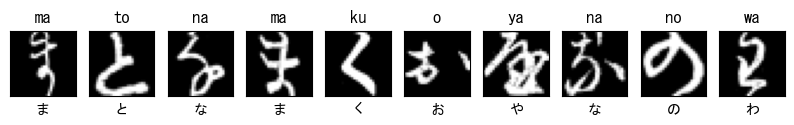

In [18]:
# Sets font for plot that supports Hiragana
plt.rcParams['font.family'] = 'MS Gothic'

plt.figure(figsize=(10,10))
for i in range(10):
    labels = translatedLabels[translatedLabels['index'] == trainLabel[i]]
    
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(reshapedSampledTrain[i] / 255.0, cmap = 'gray')
    plt.xlabel(labels['char'].to_string(index = False))
    plt.title(labels['english'].to_string(index = False))
plt.show()

### Model parameters and data generator preparation

In [19]:
# Define the parameters for data generator and model training
batchSize = 16
toUseTrainFirst = (reshapedSampledTrain.reshape(-1,28,28,1))
toUseTrainSecond = np.reshape(trainData, (trainData.shape[0], 28, 28, 1))
toUseTrainTransfer = resizedTrainKMNIST
toUseLabel = to_categorical(resampledTrainLabel, 49)
toUseLabelSecond = to_categorical(trainLabel, 49)

# Map KMNIST train labels
trainKMNISTLabels = trainLabelKMNIST.copy()

# Map KMNIST labels to K49 labels
kmnistNewTrainLabels = kmnistToK49(trainKMNISTLabels)

# One-hot encode the new labels
newTestKMNISTLabels = to_categorical(kmnistNewTrainLabels, 49)

# Clear up memory
del trainData, reshapedSampledTrain, resizedTrainKMNIST

In [20]:
oriGen = ImageDataGenerator(rescale = 1./255,
                            horizontal_flip = True,
                            validation_split = 0.2)

reshapedGen = ImageDataGenerator(rescale = 1./255,
                            validation_split = 0.2)

trainGenFirst = oriGen.flow(
    toUseTrainFirst,
    toUseLabel,
    batch_size = batchSize,
    subset = 'training')

validGenFirst = oriGen.flow(
    toUseTrainFirst,
    toUseLabel,
    batch_size = batchSize,
    subset = 'validation')

trainGenSecond = reshapedGen.flow(
    toUseTrainSecond,
    toUseLabelSecond,
    batch_size = batchSize,
    subset = 'training')

validGenSecond = reshapedGen.flow(
    toUseTrainSecond,
    toUseLabelSecond,
    batch_size = batchSize,
    subset = 'validation')

trainGenTransfer = oriGen.flow(
    toUseTrainTransfer,
    newTestKMNISTLabels,
    batch_size = batchSize,
    subset = 'training')

validGenTransfer = oriGen.flow(
    toUseTrainTransfer,
    newTestKMNISTLabels,
    batch_size = batchSize,
    subset = 'validation')

## Define input shape for models

In [21]:
# Define the parameters for all three models
firstInput = Input(shape = (toUseTrainFirst.shape[1:]))
secInput = Input(shape = (toUseTrainSecond.shape[1:]))
baseInput = Input(shape = (toUseTrainTransfer.shape[1:]))

# Callback for models
callback = EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 5, restore_best_weights = True)

# Set training and validation seed for consistent results
setSeed()

In [22]:
# Shake-shake regularization
class ShakeShake(Layer):
    def __init__(self, **kwargs):
        super(ShakeShake, self).__init__(**kwargs)

    def call(self, inputs, training=None):
        if training:
            alpha = K.random_uniform(shape=[tf.shape(inputs[0])[0], 1, 1, 1])
            beta = K.random_uniform(shape=[tf.shape(inputs[0])[0], 1, 1, 1])
        else:
            alpha = 0.5
            beta = 0.5
        return inputs[0] * alpha + inputs[1] * beta

    def compute_output_shape(self, input_shape):
        return input_shape[0]
    
    def get_config(self):
        config = super(ShakeShake, self).get_config()
        return config

# Custom branches for each model to be used with shake-shake regularizer
def transferBranch(input_tensor, filters, kernel_size, name):
    x = ZeroPadding2D(padding = (2,2))(input_tensor)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', name=f'{name}_conv1')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', name=f'{name}_conv2')(x)
    x = MaxPooling2D(strides = 1)(x)
    x = Dropout(0.4)(x)
    return x

def firstBranch(input_tensor, filters, kernel_size, name):
    x = ZeroPadding2D(padding = (2,2))(input_tensor)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', name=f'{name}_conv1')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.4)(x)
    return x

def secBranch(input_tensor, filters, kernel_size, name):
    x = ZeroPadding2D(padding = (2,2))(input_tensor)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', name=f'{name}_conv1')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', name=f'{name}_conv2')(x)
    x = MaxPooling2D(strides = 1)(x)
    x = Dropout(0.4)(x)
    return x

# First CNN

In [23]:
# First branch
firstShake1 = firstBranch(firstInput, 64, (3, 3), 'branch1')

# Second branch
firstShake2 = firstBranch(firstInput, 64, (3, 3), 'branch2')

# Shake-Shake layer to combine branches
firstShakeShake = ShakeShake()([firstShake1, firstShake2])

x = Conv2D(128, (3, 3), activation = 'relu')(firstShakeShake)
x = MaxPooling2D(strides = 1)(x)
x = Dropout(0.6)(x)
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
output_tensor = Dense(49, activation = 'softmax')(x)

# Define the model
firstModel = tf.keras.Model(inputs = firstInput, outputs = output_tensor)
firstModel._name = "CNN_1"
firstModel.summary()
print(len(firstModel.layers))

Model: "CNN_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)   0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 32, 32, 1)   0           ['input_1[0][0]']                
 D)                                                                                               
                                                                                                  
 branch1_conv1 (Conv2D)         (None, 32, 32, 64)   640         ['zero_padding2d[0][0]']     

In [24]:
firstModel.compile(
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(),  
    
    # Loss function to minimize
    loss = tf.keras.losses.CategoricalCrossentropy(),
    
    # List of metrics to monitor
    metrics = ['accuracy'],
)

In [25]:
firstTrained = firstModel.fit(trainGenFirst, epochs = 100, callbacks = callback, 
                              steps_per_epoch = len(trainGenFirst) // batchSize, 
                              validation_data = validGenFirst, validation_steps = len(validGenFirst) // batchSize)

Epoch 1/100
918/918 [==============================] - 19s 12ms/step - loss: 2.0136 - accuracy: 0.4847 - val_loss: 1.2587 - val_accuracy: 0.6782
Epoch 2/100
918/918 [==============================] - 11s 12ms/step - loss: 1.1441 - accuracy: 0.6946 - val_loss: 0.8931 - val_accuracy: 0.7707
Epoch 3/100
918/918 [==============================] - 11s 12ms/step - loss: 0.9076 - accuracy: 0.7579 - val_loss: 0.7335 - val_accuracy: 0.7983
Epoch 4/100
918/918 [==============================] - 11s 12ms/step - loss: 0.7944 - accuracy: 0.7843 - val_loss: 0.6064 - val_accuracy: 0.8305
Epoch 5/100
918/918 [==============================] - 11s 12ms/step - loss: 0.7258 - accuracy: 0.8079 - val_loss: 0.5934 - val_accuracy: 0.8376
Epoch 6/100
918/918 [==============================] - 11s 12ms/step - loss: 0.6735 - accuracy: 0.8196 - val_loss: 0.5256 - val_accuracy: 0.8534
Epoch 7/100
918/918 [==============================] - 11s 12ms/step - loss: 0.6304 - accuracy: 0.8317 - val_loss: 0.4850 - val_ac

# Second CNN

In [26]:
# First branch
secModelBranch1 = secBranch(secInput, 32, (3, 3), 'branch1')

# Second branch
secModelBranch2 = secBranch(secInput, 32, (3, 3), 'branch2')

# Shake-shake layer to combine branches
shakeShake = ShakeShake()([secModelBranch1, secModelBranch2])

x = ZeroPadding2D(padding = (2, 2))(shakeShake)
x = Conv2D(256, (3, 3), activation = 'relu')(x)
x = MaxPooling2D(strides = 1)(x)
x = Conv2D(256, (3, 3), activation = 'relu')(x)
x = MaxPooling2D(strides = 1)(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
output = Dense(49, activation = 'softmax')(x)

secondModel = Model(inputs = secInput, outputs = output, name = "CNN_2")

secondModel.summary()
print(len(secondModel.layers))

Model: "CNN_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 32, 32, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 32, 32, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                              

In [27]:
secondModel.compile(
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(),  
    
    # Loss function to minimize
    loss = tf.keras.losses.CategoricalCrossentropy(),
    
    # List of metrics to monitor
    metrics = ['accuracy'],
)

In [28]:
secondTrained = secondModel.fit(trainGenSecond, epochs = 100, callbacks = callback, 
                                steps_per_epoch = len(trainGenSecond) // batchSize, 
                                validation_data = validGenSecond, validation_steps = len(validGenSecond) // batchSize)

Epoch 1/100
726/726 [==============================] - 12s 16ms/step - loss: 1.6931 - accuracy: 0.5627 - val_loss: 0.8726 - val_accuracy: 0.7624
Epoch 2/100
726/726 [==============================] - 11s 16ms/step - loss: 0.7800 - accuracy: 0.7901 - val_loss: 0.4978 - val_accuracy: 0.8553
Epoch 3/100
726/726 [==============================] - 11s 16ms/step - loss: 0.5819 - accuracy: 0.8446 - val_loss: 0.3870 - val_accuracy: 0.8881
Epoch 4/100
726/726 [==============================] - 11s 16ms/step - loss: 0.4782 - accuracy: 0.8690 - val_loss: 0.3714 - val_accuracy: 0.9012
Epoch 5/100
726/726 [==============================] - 11s 16ms/step - loss: 0.4316 - accuracy: 0.8812 - val_loss: 0.3671 - val_accuracy: 0.8999
Epoch 6/100
726/726 [==============================] - 11s 16ms/step - loss: 0.3902 - accuracy: 0.8927 - val_loss: 0.3062 - val_accuracy: 0.9189
Epoch 7/100
726/726 [==============================] - 11s 16ms/step - loss: 0.3709 - accuracy: 0.8985 - val_loss: 0.2648 - val_ac

# Transfer Model Pre-training

In [29]:
densenetModel = DenseNet121(include_top = False, weights = 'imagenet', input_tensor = baseInput)

print(len(densenetModel.layers))
densenetModel.summary()

427
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d_5[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]'

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 16, 16, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 8, 8, 128)    20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 8, 8, 320)   0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 8, 8, 448)   0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 8, 8, 128)    57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 4, 4, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 4, 4, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 4, 4, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 4, 4, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 4, 4, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 4, 4, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 4, 4, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 4, 4, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 4, 4, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 4, 4, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 4, 4, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 4, 4, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 4, 4, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 4, 4, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 4, 4, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 2, 2, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 2, 2, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 2, 2, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 2, 2, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 2, 2, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 2, 2, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 2, 2, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 2, 2, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 2, 2, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 2, 2, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

In [30]:
# First branch
transferBranch1 = transferBranch(densenetModel.output, 32, (3,3), 'branch1')

# Second branch
transferBranch2 = transferBranch(densenetModel.output, 32, (3,3), 'branch2')

# Shake-Shake layer to combine branches
x = ShakeShake()([transferBranch1, transferBranch2])
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
output = Dense(49, activation = 'softmax')(x)

# Create the final model
final_model = Model(inputs = densenetModel.input, outputs = output)
final_model._name = "Transfer_Model"

# Set trainable layers to false to maintain the weights for transfer learning
for layer in final_model.layers[:290]:
    layer.trainable = False

for layer in final_model.layers[290:]:
    layer.trainable = True

In [31]:
print(len(final_model.layers))
final_model.summary()

444
Model: "Transfer_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d_5[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 16, 16, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 8, 8, 128)    20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 8, 8, 320)   0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 8, 8, 448)   0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 8, 8, 128)    57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 4, 4, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 4, 4, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 4, 4, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 4, 4, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 4, 4, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 4, 4, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 4, 4, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 4, 4, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 4, 4, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 4, 4, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 4, 4, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 4, 4, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 4, 4, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 4, 4, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 4, 4, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 2, 2, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 2, 2, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 2, 2, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 2, 2, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 2, 2, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 2, 2, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 2, 2, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 2, 2, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 2, 2, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 2, 2, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

 )                                                                                                
                                                                                                  
 branch1_conv2 (Conv2D)         (None, 3, 3, 32)     9248        ['max_pooling2d_9[0][0]']        
                                                                                                  
 branch2_conv2 (Conv2D)         (None, 3, 3, 32)     9248        ['max_pooling2d_11[0][0]']       
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 2, 2, 32)    0           ['branch1_conv2[0][0]']          
 )                                                                                                
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 2, 2, 32)    0           ['branch2_conv2[0][0]']          
 )        

In [32]:
final_model.compile(
    # Optimizer
    optimizer=tf.keras.optimizers.Adam(decay = 0.01 / 100),  
    
    # Loss function to minimize
    loss=tf.keras.losses.CategoricalCrossentropy(),
    
    # List of metrics to monitor
    metrics=['accuracy'],
)

In [33]:
finalTrained = final_model.fit(trainGenTransfer, epochs = 100, callbacks = callback, 
                               steps_per_epoch = len(trainGenTransfer) // batchSize, 
                               validation_data = validGenTransfer, validation_steps = len(validGenTransfer) // batchSize)

Epoch 1/100
187/187 [==============================] - 20s 70ms/step - loss: 1.4960 - accuracy: 0.5605 - val_loss: 1.1436 - val_accuracy: 0.6848
Epoch 2/100
187/187 [==============================] - 11s 58ms/step - loss: 0.8265 - accuracy: 0.7861 - val_loss: 0.7818 - val_accuracy: 0.7609
Epoch 3/100
187/187 [==============================] - 11s 58ms/step - loss: 0.6877 - accuracy: 0.8272 - val_loss: 0.5971 - val_accuracy: 0.8247
Epoch 4/100
187/187 [==============================] - 11s 59ms/step - loss: 0.5561 - accuracy: 0.8623 - val_loss: 0.2918 - val_accuracy: 0.9239
Epoch 5/100
187/187 [==============================] - 11s 59ms/step - loss: 0.5024 - accuracy: 0.8780 - val_loss: 0.2857 - val_accuracy: 0.9158
Epoch 6/100
187/187 [==============================] - 11s 58ms/step - loss: 0.4158 - accuracy: 0.8961 - val_loss: 0.2800 - val_accuracy: 0.9144
Epoch 7/100
187/187 [==============================] - 11s 58ms/step - loss: 0.4075 - accuracy: 0.9051 - val_loss: 0.2685 - val_ac

# Plotting of Model History

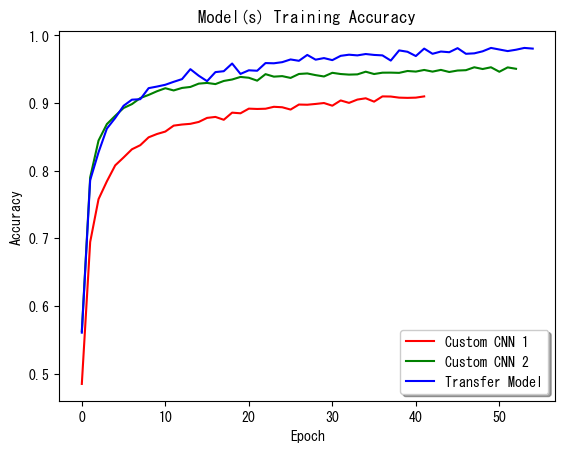

In [34]:
plt.plot(firstTrained.history['accuracy'], color = 'r')
plt.plot(secondTrained.history['accuracy'], color = 'g')
plt.plot(finalTrained.history['accuracy'], color = 'b')
plt.title('Model(s) Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Custom CNN 1', 'Custom CNN 2', 'Transfer Model'], loc='best', shadow = True)
plt.show()

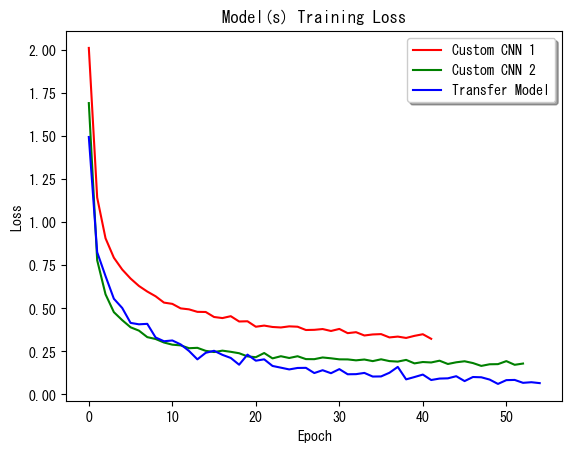

In [35]:
plt.plot(firstTrained.history['loss'], color = 'r')
plt.plot(secondTrained.history['loss'], color = 'g')
plt.plot(finalTrained.history['loss'], color = 'b')
plt.title('Model(s) Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Custom CNN 1', 'Custom CNN 2', 'Transfer Model'], loc='best', shadow = True)
plt.show()

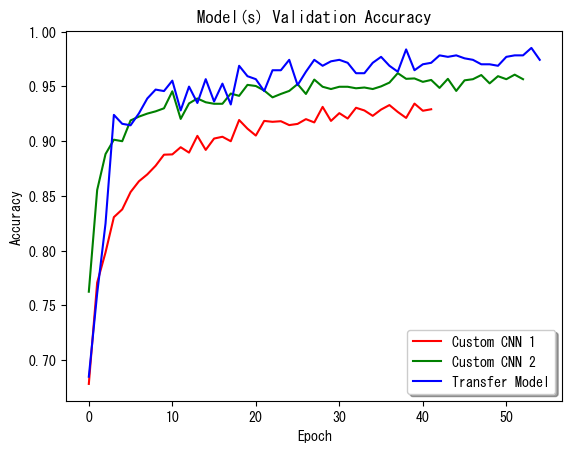

In [36]:
plt.plot(firstTrained.history['val_accuracy'], color = 'r')
plt.plot(secondTrained.history['val_accuracy'], color = 'g')
plt.plot(finalTrained.history['val_accuracy'], color = 'b')
plt.title('Model(s) Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Custom CNN 1', 'Custom CNN 2', 'Transfer Model'], loc='best', shadow = True)
plt.show()

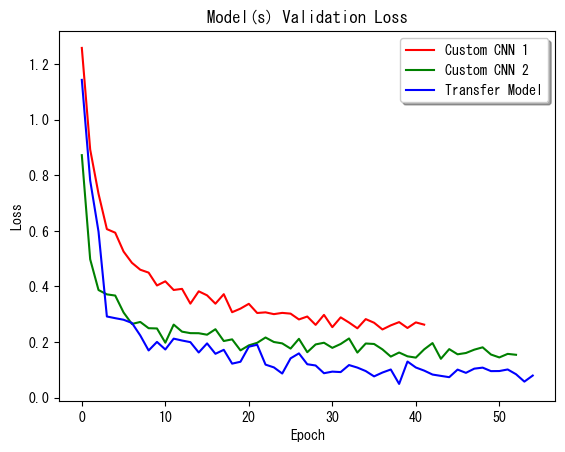

In [37]:
plt.plot(firstTrained.history['val_loss'], color = 'r')
plt.plot(secondTrained.history['val_loss'], color = 'g')
plt.plot(finalTrained.history['val_loss'], color = 'b')
plt.title('Model(s) Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Custom CNN 1', 'Custom CNN 2', 'Transfer Model'], loc='best', shadow = True)
plt.show()

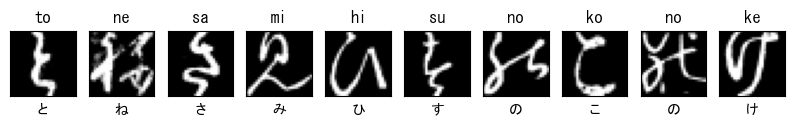

In [38]:
# View test set of K49 data
actualLabels = []

plt.figure(figsize=(10,10))
for i in range(10):
    actualLabels.append(translatedLabels[translatedLabels['index'] == testLabel[i]])
    
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testData[i], cmap = 'gray')
    plt.xlabel(actualLabels[i]['char'].to_string(index = False))
    plt.title(actualLabels[i]['english'].to_string(index = False))
plt.show()

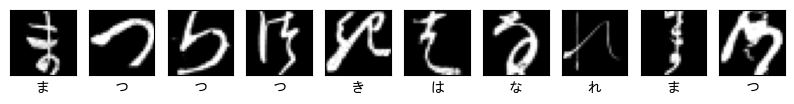

In [39]:
# View test set of KMNIST data
actualLabel = []

plt.figure(figsize=(10,10))
for i in range(10):
    actualLabel.append(labelIndicesKMNIST[labelIndicesKMNIST['index'] == testLabelKMNIST[i+10]])
    
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testDataKMNIST[i+10], cmap = 'gray')
    plt.xlabel(actualLabel[i]['char'].to_string(index = False))
plt.show()

# Testing Model Predictions

## First Model

In [40]:
for i in range(10):
    predSet = testData[0:10]
    test = predSet[i].reshape(1,testData.shape[1],testData.shape[2],1)
    pred = firstModel.predict(test)
    print('Predicted output : ', translatedLabels[translatedLabels['index'] == np.argmax(pred)]['char'].to_string(index = False))
    print('Actual output : ', actualLabels[i]['char'].to_string(index = False))

1/1 [==============================] - 0s 140ms/step
Predicted output :  と
Actual output :  と
1/1 [==============================] - 0s 23ms/step
Predicted output :  ね
Actual output :  ね
1/1 [==============================] - 0s 25ms/step
Predicted output :  さ
Actual output :  さ
1/1 [==============================] - 0s 23ms/step
Predicted output :  め
Actual output :  み
1/1 [==============================] - 0s 25ms/step
Predicted output :  ひ
Actual output :  ひ
1/1 [==============================] - 0s 26ms/step
Predicted output :  す
Actual output :  す
1/1 [==============================] - 0s 24ms/step
Predicted output :  の
Actual output :  の
1/1 [==============================] - 0s 24ms/step
Predicted output :  こ
Actual output :  こ
1/1 [==============================] - 0s 24ms/step
Predicted output :  の
Actual output :  の
1/1 [==============================] - 0s 26ms/step
Predicted output :  け
Actual output :  け


In [41]:
# Read in test image to check if predicition is correct
img = tf.io.read_file('images/i.jpg')
img = tf.image.decode_jpeg(img, channels=1)
img = tf.image.resize(img, [testData.shape[1], testData.shape[2]])
img = tf.cast(img, tf.float32)
test = np.expand_dims(img, axis=0)

newPredFirst = firstModel.predict(test)

print('Predicted output : ', translatedLabels[translatedLabels['index'] == np.argmax(newPredFirst)]['char'].to_string(index = False))

1/1 [==============================] - 0s 22ms/step
Predicted output :  い


## Second Model

In [42]:
for i in range(10):
    predSet = toUseTrainSecond[0:10]
    test = predSet[i].reshape(1,toUseTrainSecond.shape[1],toUseTrainSecond.shape[2],1)
    pred = secondModel.predict(test)
    print('Predicted output : ', translatedLabels[translatedLabels['index'] == np.argmax(pred)]['char'].to_string(index = False))
    print('Actual output : ', actualLabels[i]['char'].to_string(index = False))

1/1 [==============================] - 0s 177ms/step
Predicted output :  ま
Actual output :  と
1/1 [==============================] - 0s 23ms/step
Predicted output :  と
Actual output :  ね
1/1 [==============================] - 0s 22ms/step
Predicted output :  な
Actual output :  さ
1/1 [==============================] - 0s 24ms/step
Predicted output :  ま
Actual output :  み
1/1 [==============================] - 0s 24ms/step
Predicted output :  く
Actual output :  ひ
1/1 [==============================] - 0s 26ms/step
Predicted output :  お
Actual output :  す
1/1 [==============================] - 0s 26ms/step
Predicted output :  な
Actual output :  の
1/1 [==============================] - 0s 24ms/step
Predicted output :  な
Actual output :  こ
1/1 [==============================] - 0s 24ms/step
Predicted output :  の
Actual output :  の
1/1 [==============================] - 0s 26ms/step
Predicted output :  わ
Actual output :  け


In [43]:
# Read in test image to check if predicition is correct
testLabels = np.reshape(testData, (testData.shape[0], 28, 28, 1))

img = tf.io.read_file('images/i.jpg')
img = tf.image.decode_jpeg(img, channels=1)
img = tf.image.resize(img, [testLabels.shape[1], testLabels.shape[2]])
img = tf.cast(img, tf.float32)
test = np.expand_dims(img, axis=0)

newPredSec = secondModel.predict(test)

print('Predicted output : ', translatedLabels[translatedLabels['index'] == np.argmax(newPredSec)]['char'].to_string(index = False))

1/1 [==============================] - 0s 94ms/step
Predicted output :  い


## Third Model

In [44]:
for i in range(10):
    predSet = resizedTestKMNIST[i]
    test = predSet.reshape(1,resizedTestKMNIST.shape[1],resizedTestKMNIST.shape[2],3)
    predFinal = final_model.predict(test)
    print('Predicted output : ', translatedLabels[translatedLabels['index'] == np.argmax(predFinal)]['char'].to_string(index = False))
    print('Actual output : ', actualLabel[i]['char'].to_string(index = False))

1/1 [==============================] - 2s 2s/step
Predicted output :  す
Actual output :  ま
1/1 [==============================] - 0s 41ms/step
Predicted output :  を
Actual output :  つ
1/1 [==============================] - 0s 41ms/step
Predicted output :  つ
Actual output :  つ
1/1 [==============================] - 0s 43ms/step
Predicted output :  れ
Actual output :  つ
1/1 [==============================] - 0s 46ms/step
Predicted output :  つ
Actual output :  き
1/1 [==============================] - 0s 44ms/step
Predicted output :  つ
Actual output :  は
1/1 [==============================] - 0s 42ms/step
Predicted output :  れ
Actual output :  な
1/1 [==============================] - 0s 43ms/step
Predicted output :  を
Actual output :  れ
1/1 [==============================] - 0s 42ms/step
Predicted output :  す
Actual output :  ま
1/1 [==============================] - 0s 42ms/step
Predicted output :  は
Actual output :  つ


In [45]:
# Read in test image to check if predicition is correct
img = tf.io.read_file('images/i.jpg')
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [resizedTestKMNIST.shape[1], resizedTestKMNIST.shape[2]])
img = tf.cast(img, tf.float32)
test = np.expand_dims(img, axis=0)

newPredTransfer = final_model.predict(test)

print('Predicted output : ', translatedLabels[translatedLabels['index'] == np.argmax(newPredTransfer)]['char'].to_string(index = False))

1/1 [==============================] - 0s 39ms/step
Predicted output :  つ


# Max-sum test

In [46]:
print(newPredFirst.shape)
print(newPredSec.shape)
print(newPredTransfer.shape)

# Try mapping the KMNIST labels to K49 labels
allPreds = np.stack([newPredFirst, newPredSec, newPredTransfer])
summedPreds = np.sum(allPreds, axis=0)

(1, 49)
(1, 49)
(1, 49)


In [47]:
# If you need the predicted probabilities
finalProbs = np.max(summedPreds, axis=1)

print('Predicted output : ', translatedLabels[translatedLabels['index'] == np.argmax(summedPreds)]['char'].to_string(index = False))

Predicted output :  い


# Model Postprocessing

### First Model

In [48]:
# Run the model prediction on test set with CPU
testPredData = testData.reshape(testData.shape[0], testData.shape[1], testData.shape[2],1)

with tf.device('/CPU:0'):
    predLabelsFirst = np.argmax(firstModel.predict(testPredData), axis=-1)

1205/1205 [==============================] - 44s 36ms/step


In [49]:
# Get the precision, recall, and F1-score
report = classification_report(testLabel, predLabelsFirst, labels = translatedLabels['index'], target_names = translatedLabels['char'])

# Get the confusion matrix
confusion = confusion_matrix(testLabel, predLabelsFirst, labels = translatedLabels['index'])

print(report)

              precision    recall  f1-score   support

           あ       0.93      0.89      0.91      1000
           い       0.97      0.91      0.94      1000
           う       0.88      0.94      0.91      1000
           え       0.66      0.78      0.72       126
           お       0.91      0.86      0.88      1000
           か       0.91      0.80      0.85      1000
           き       0.81      0.82      0.81      1000
           く       0.89      0.82      0.85      1000
           け       0.75      0.84      0.79       767
           こ       0.91      0.86      0.88      1000
           さ       0.88      0.91      0.89      1000
           し       0.90      0.88      0.89      1000
           す       0.84      0.82      0.83      1000
           せ       0.81      0.79      0.80       678
           そ       0.71      0.82      0.76       629
           た       0.86      0.84      0.85      1000
           ち       0.92      0.92      0.92       418
           つ       0.83    

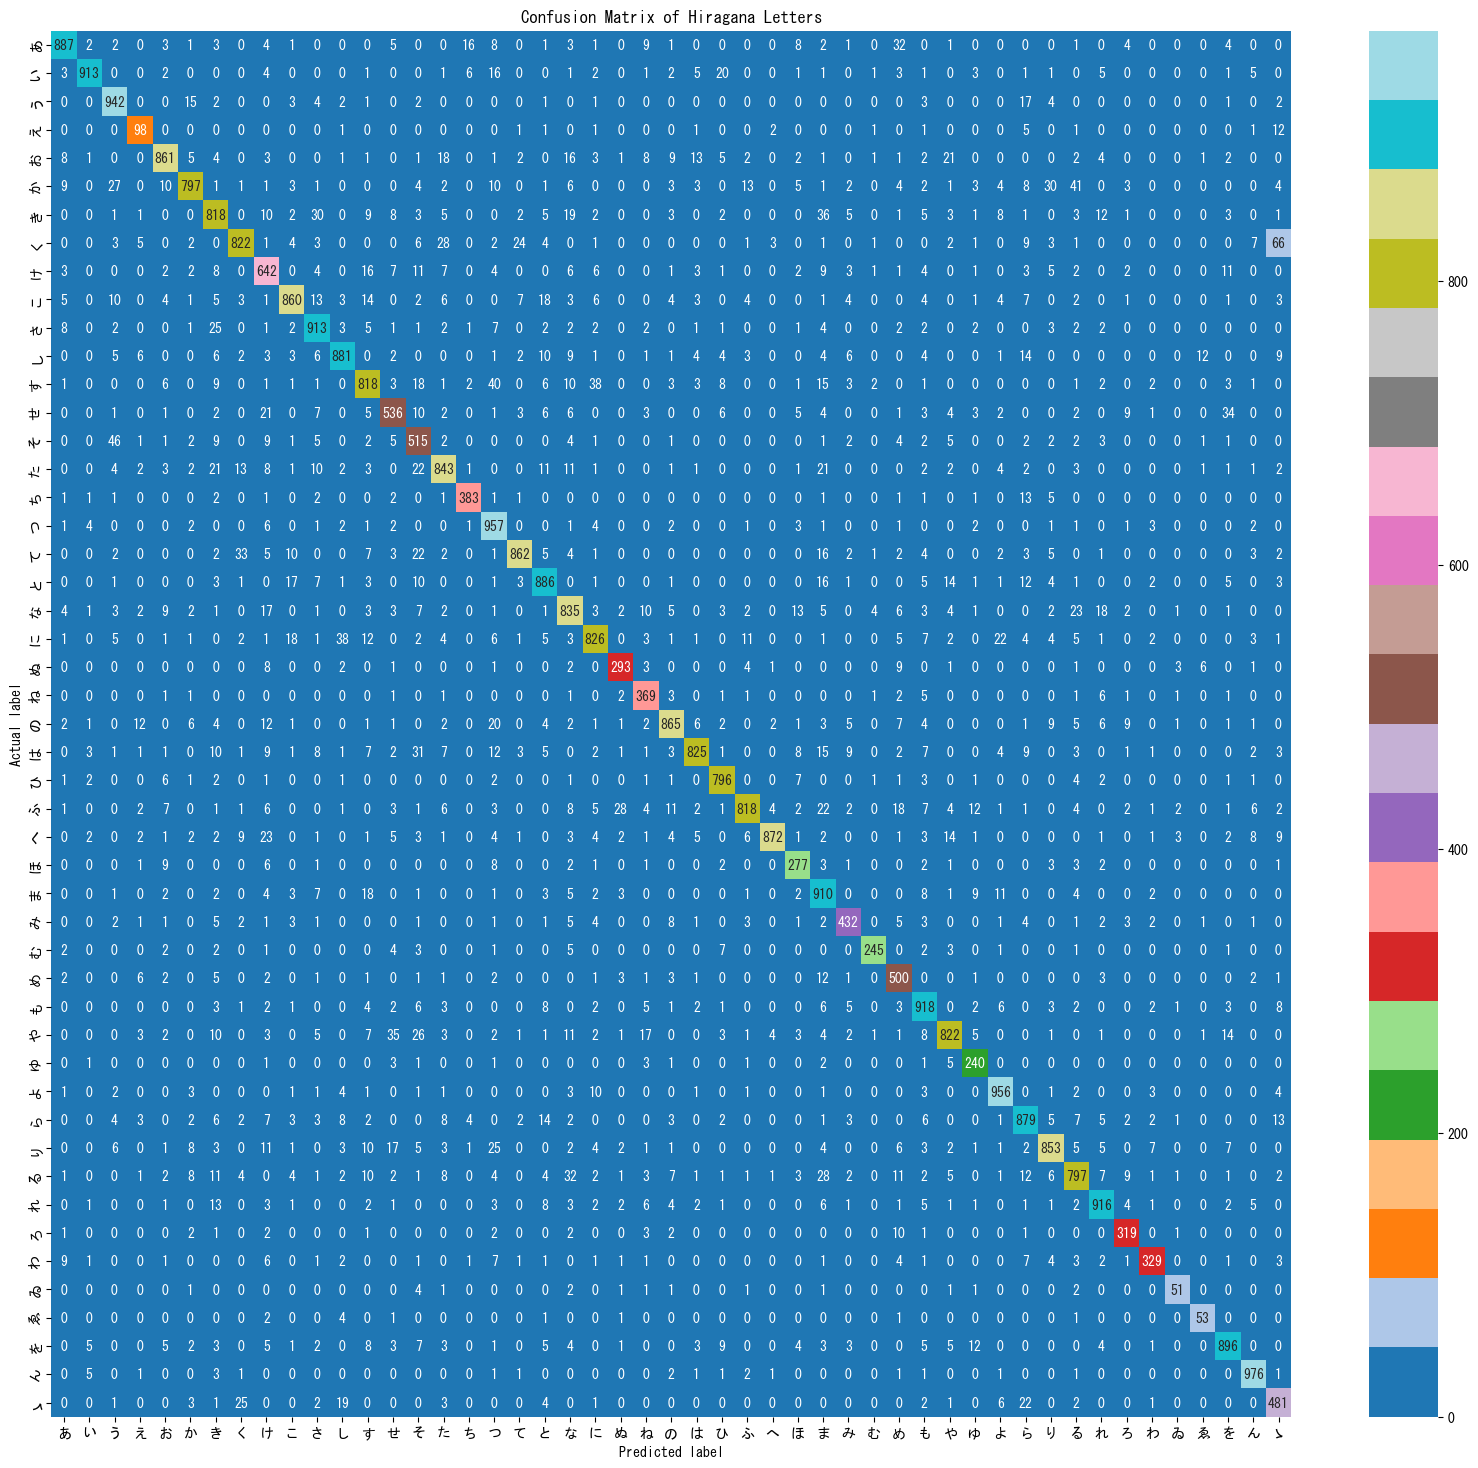

In [50]:
# Print out the confusion matrix using seaborn heatmap
dfConfusion = pd.DataFrame(confusion, index = translatedLabels['char'], columns = translatedLabels['char'])

plt.figure(figsize=(20,18))
sns.heatmap(dfConfusion, annot=True, fmt='d', cmap = 'tab20')
plt.title("Confusion Matrix of Hiragana Letters")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

### Second Model

In [51]:
# Run the model prediction on test set with CPU
with tf.device('/CPU:0'):
    predLabelsSec = np.argmax(secondModel.predict(testPredData), axis=-1)

1205/1205 [==============================] - 61s 50ms/step


In [52]:
# Get the precision, recall, and F1-score
report = classification_report(testLabel, predLabelsSec, labels = translatedLabels['index'], target_names = translatedLabels['char'])

# Get the confusion matrix
confusion = confusion_matrix(testLabel, predLabelsSec, labels = translatedLabels['index'])

print(report)

              precision    recall  f1-score   support

           あ       0.91      0.96      0.94      1000
           い       0.97      0.96      0.97      1000
           う       0.93      0.96      0.94      1000
           え       0.85      0.94      0.89       126
           お       0.93      0.92      0.92      1000
           か       0.91      0.89      0.90      1000
           き       0.96      0.86      0.91      1000
           く       0.93      0.89      0.91      1000
           け       0.83      0.95      0.89       767
           こ       0.89      0.95      0.92      1000
           さ       0.95      0.93      0.94      1000
           し       0.92      0.94      0.93      1000
           す       0.90      0.86      0.88      1000
           せ       0.97      0.83      0.89       678
           そ       0.88      0.90      0.89       629
           た       0.91      0.94      0.93      1000
           ち       0.96      0.94      0.95       418
           つ       0.94    

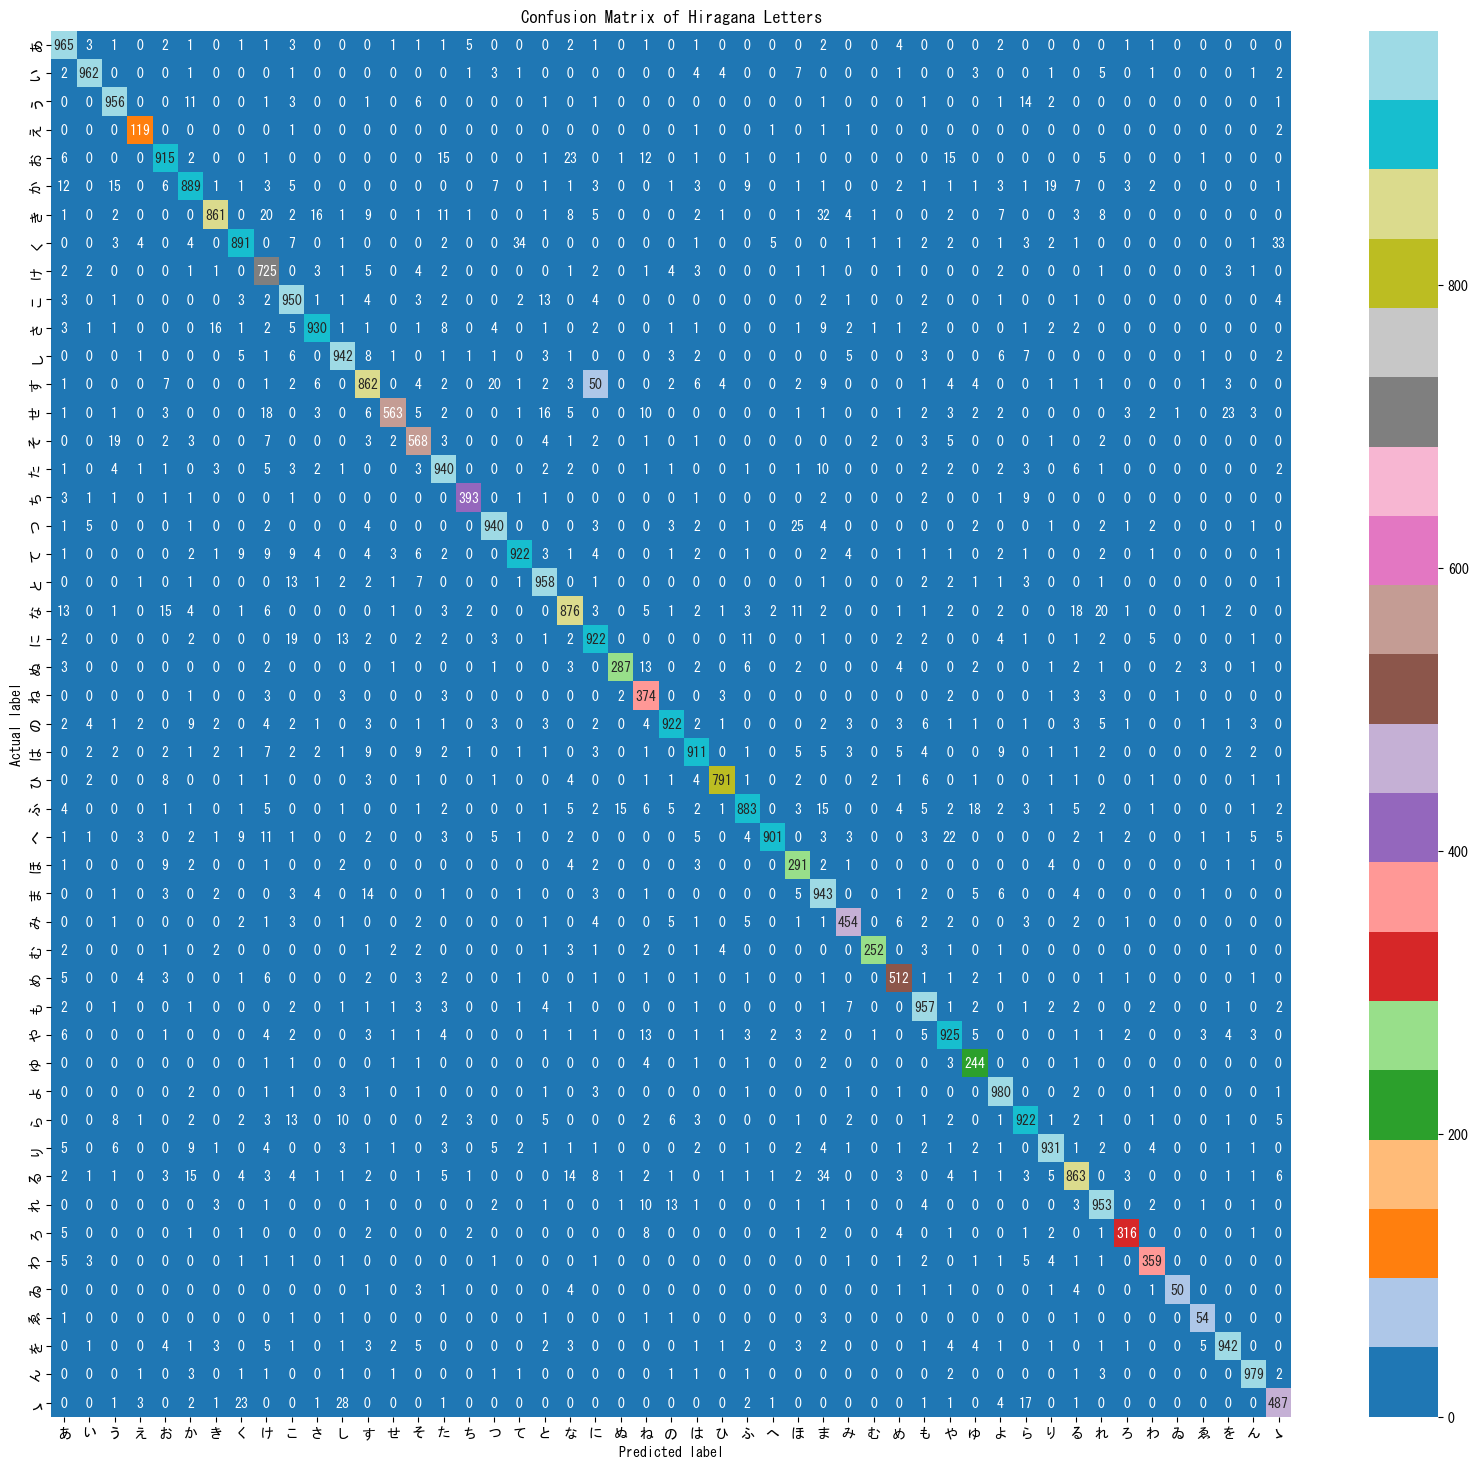

In [53]:
# Print out the confusion matrix using seaborn heatmap
dfConfusion = pd.DataFrame(confusion, index = translatedLabels['char'], columns = translatedLabels['char'])

plt.figure(figsize=(20,18))
sns.heatmap(dfConfusion, annot=True, fmt='d', cmap = 'tab20')
plt.title("Confusion Matrix of Hiragana Letters")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

### Third Model

In [54]:
# Run the model prediction on test set with CPU
with tf.device('/CPU:0'):
    predLabels = np.argmax(final_model.predict(resizedTestKMNIST), axis=-1)

313/313 [==============================] - 64s 200ms/step


In [55]:
# Get the precision, recall, and F1-score
report = classification_report(kmnistNewLabels, predLabels, labels = translatedLabels['index'], target_names = translatedLabels['char'], output_dict=True)

# Convert the dictionary to a DataFrame
dfReport = pd.DataFrame(report).transpose()

# Remove rows where 'support' is 0
filteredReport = dfReport[dfReport['support'] != 0]

# Get the confusion matrix
confusion = confusion_matrix(kmnistNewLabels, predLabels, labels = translatedLabels['index'])

display(filteredReport)

,precision,recall,f1-score,support
お,0.966000,0.966000,0.966000,1000.0
く,0.953299,0.939000,0.946096,1000.0
す,0.904854,0.932000,0.918227,1000.0
つ,0.943961,0.977000,0.960197,1000.0
な,0.941709,0.937000,0.939348,1000.0
は,0.976571,0.917000,0.945848,1000.0
ま,0.943842,0.958000,0.950868,1000.0
や,0.964575,0.953000,0.958753,1000.0
れ,0.963928,0.962000,0.962963,1000.0
を,0.961576,0.976000,0.968734,1000.0


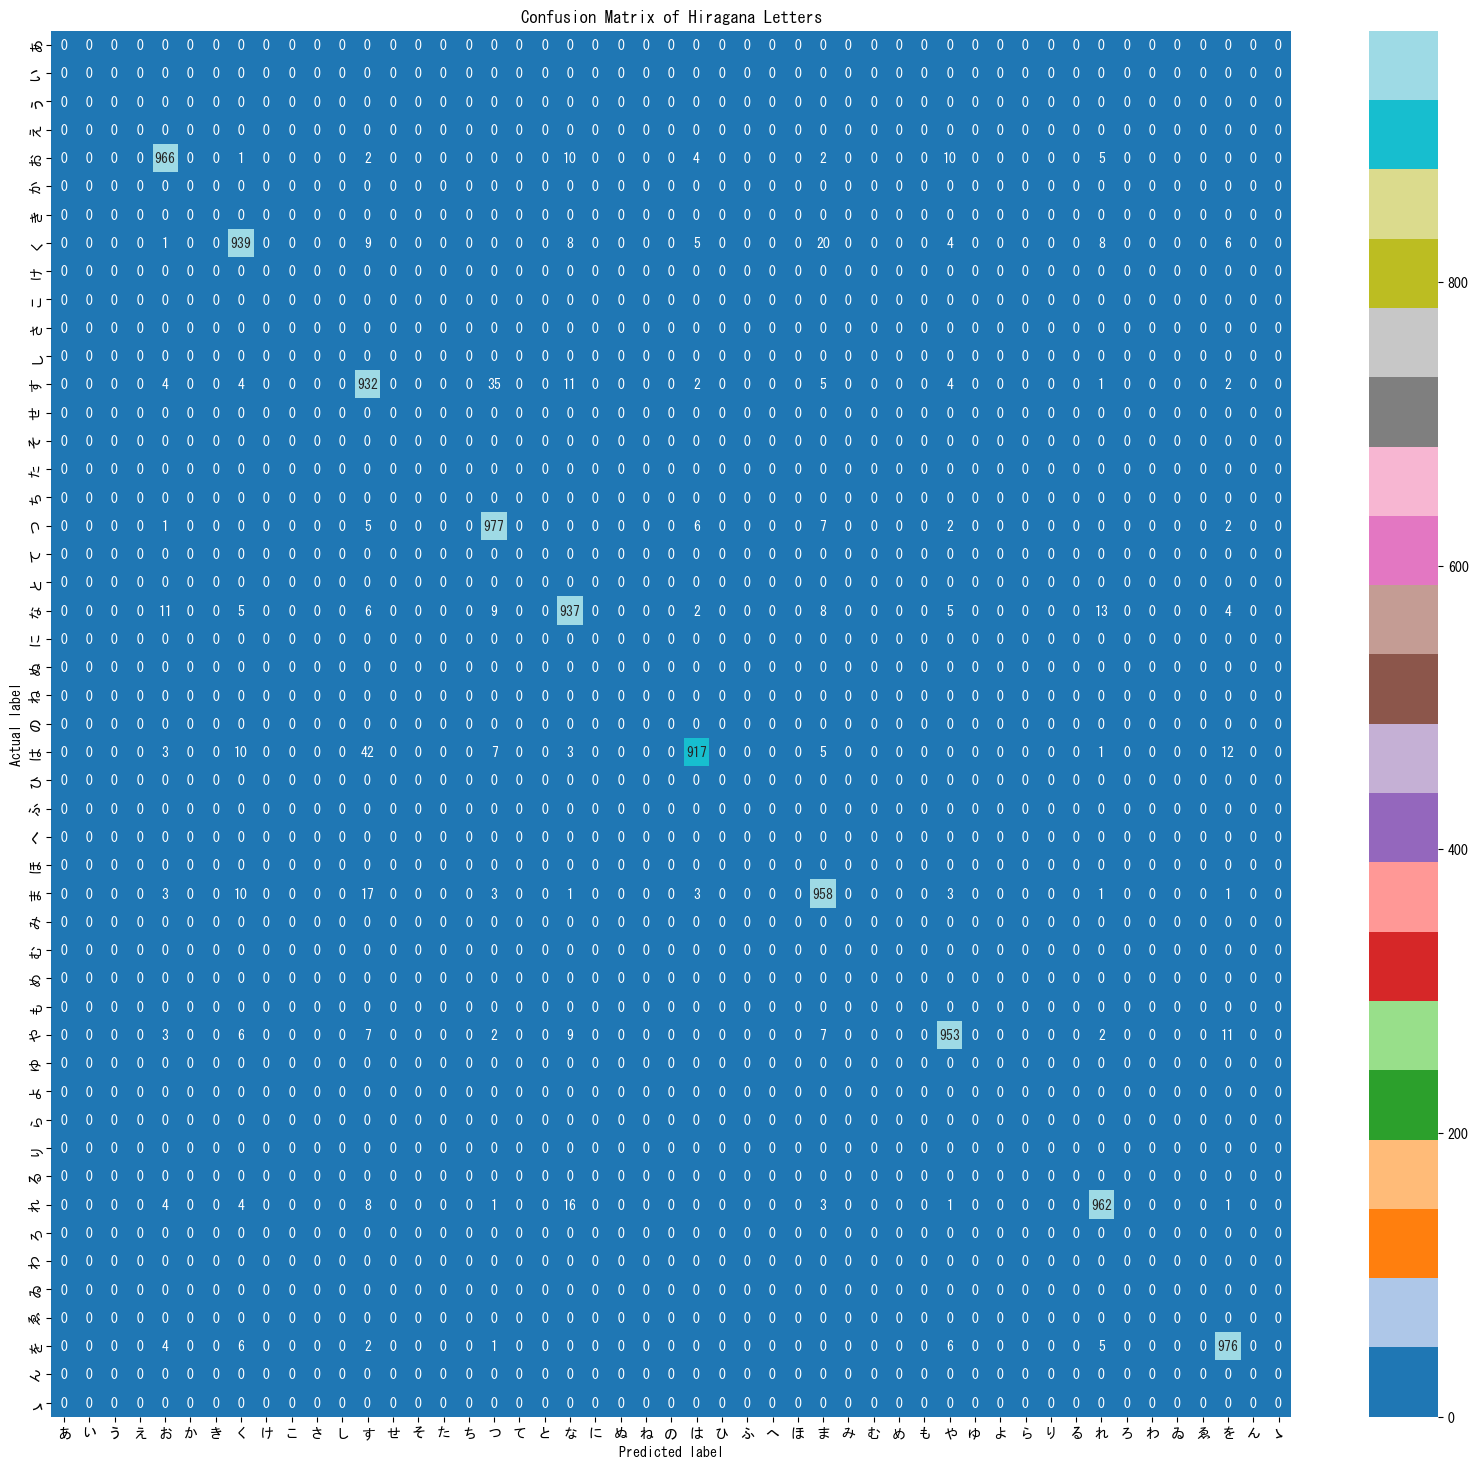

In [56]:
# Print out the confusion matrix using seaborn heatmap
dfConfusion = pd.DataFrame(confusion, index = translatedLabels['char'], columns = translatedLabels['char'])

plt.figure(figsize=(20,18))
sns.heatmap(dfConfusion, annot=True, fmt='d', cmap = 'tab20')
plt.title("Confusion Matrix of Hiragana Letters")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

In [57]:
# Check which variables are using a high amount of memory
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


# Do garbage collection on unused objects
gc.collect()

            toUseTrainTransfer:  5.5 GiB
             resizedTestKMNIST: 937.5 MiB
                      testData: 230.6 MiB
            resampledTrainData: 219.8 MiB
               trainDataKMNIST: 44.9 MiB
                testDataKMNIST:  7.5 MiB
               predLabelsFirst: 301.3 KiB
                 predLabelsSec: 301.3 KiB
           resampledTrainLabel: 287.2 KiB
          kmnistNewTrainLabels: 234.5 KiB


160333

## Save Models and Run Results

In [58]:
# File path to csv file for saving training results
csvPath = os.getcwd() + '\\Training_History.csv'
currentTime = datetime.now()

columns = ['Date of run', 'Model Name', 'Highest accuracy',
           'Number of layers', 'Batch size', 'Total Epochs', 'Testing Accuracy']

firstCNN = {'Date of run': currentTime.strftime("%d/%m/%Y %X"), 
            'Model Name': firstModel.name,
            'Highest accuracy': max(firstTrained.history['val_accuracy']), 
            'Number of layers': len(firstModel.layers), 
            'Batch size': batchSize, 
            'Total Epochs': len(firstTrained.history['val_accuracy']), 
            'Testing Accuracy': np.mean(predLabelsFirst == testLabel)}

secondCNN = {'Date of run': '', 
             'Model Name': secondModel.name,
             'Highest accuracy': max(secondTrained.history['val_accuracy']), 
             'Number of layers': len(secondModel.layers),
             'Batch size': batchSize, 
             'Total Epochs': len(secondTrained.history['val_accuracy']), 
             'Testing Accuracy': np.mean(predLabelsSec == testLabel)}

transferCNN = {'Date of run': '', 
               'Model Name': final_model.name,
               'Highest accuracy': max(finalTrained.history['val_accuracy']), 
               'Number of layers': len(final_model.layers),
               'Batch size': batchSize, 
               'Total Epochs': len(finalTrained.history['val_accuracy']), 
               'Testing Accuracy': accuracy_score(kmnistNewLabels, predLabels)}

In [59]:
# Save results, model layers and date of current run
if(os.path.exists(csvPath)):
    dfCurrent = pd.DataFrame([firstCNN])
    dfCurrent.to_csv('Training_History.csv', mode = 'a', index = False, header = False)
    
    dfCurrent = pd.DataFrame([secondCNN])
    dfCurrent.to_csv('Training_History.csv', mode = 'a', index = False, header = False)
    
    dfCurrent = pd.DataFrame([transferCNN])
    dfCurrent.to_csv('Training_History.csv', mode = 'a', index = False, header = False)
else:
    dfCurrent = pd.DataFrame([firstCNN])
    dfCurrent.to_csv('Training_History.csv', index = False)
    
    dfCurrent = pd.DataFrame([secondCNN])
    dfCurrent.to_csv('Training_History.csv', mode = 'a', index = False, header = False)
    
    dfCurrent = pd.DataFrame([transferCNN])
    dfCurrent.to_csv('Training_History.csv', mode = 'a', index = False, header = False)
    
# Save the models for future use
firstModel.save('models/CustomCNN1.h5')
secondModel.save('models/CustomCNN2.h5')
final_model.save('models/TransferLearningModel.h5')